In [81]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.


In [82]:
import cv2
import numpy as np
import albumentations as A
from albumentations import Compose, HorizontalFlip, RandomRotate90, ColorJitter, RandomCrop, GaussianBlur, Normalize
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os.path
from PIL import Image, ImageDraw
from sahi.utils.file import load_json, save_json
from tqdm import tqdm
import timm

import torchvision
import torch


In [83]:
torch.cuda.is_available()
torch.cuda.current_device()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [105]:
coco_file_name  = "cassette_val"

# Determine target split from coco_file_name
target_split = None
if "train" in coco_file_name.lower():
    target_split = "train"
elif "test" in coco_file_name.lower():
    target_split = "test"
elif "val" in coco_file_name.lower():
    target_split = "val"
if not target_split:
    raise ValueError("Unable to determine target split from coco_file_name.")

print(target_split)

DATA_DIR = os.path.join("..", "testy")
COCO_DIR = os.path.join(DATA_DIR, "coco")

ORG_ANNOTATION_PATH = os.path.join(DATA_DIR, "coco",target_split, f"{coco_file_name}_corrected_coco.json")
SLC_ANNOTATION_PATH = os.path.join(DATA_DIR, "coco",target_split, f"{coco_file_name}_sliced_coco.json")

AUGMENTATION_PATH = os.path.join(COCO_DIR, "augmentated") # Folder for all augmentations ./data/coco/augmentated

print(ORG_ANNOTATION_PATH)

#IMAGE_DIR = os.path.join(COCO_DIR, "images")
IMAGE_DIR = os.path.join(COCO_DIR, "images")
SLICED_IMAGE_DIR = os.path.join(COCO_DIR, "images_sliced",coco_file_name)

BBOX_VISUALIZATION_DIR = os.path.join(DATA_DIR, "bbox_vis", coco_file_name)
BBOX_SAVE_DIR = os.path.join(BBOX_VISUALIZATION_DIR,"each") #Place to savea each of the before augmented bounding boxes

os.path.exists(DATA_DIR)
os.path.exists(COCO_DIR)

os.path.exists(ORG_ANNOTATION_PATH)
os.path.exists(IMAGE_DIR)
os.path.exists(BBOX_VISUALIZATION_DIR)

if not os.path.exists(BBOX_SAVE_DIR):
    os.makedirs(BBOX_SAVE_DIR)

if not os.path.exists(AUGMENTATION_PATH):
    os.makedirs(AUGMENTATION_PATH)

val
..\testy\coco\val\cassette_val_corrected_coco.json


In [96]:
coco_dict = load_json(ORG_ANNOTATION_PATH)
[img.update({"file_name": img["file_name"].split("/")[-1]}) for img in coco_dict["images"]]
save_json(coco_dict, save_path=ORG_ANNOTATION_PATH)

coco_dict

{'images': [{'width': 4096,
   'height': 2000,
   'id': 4,
   'file_name': '01BN02.bmp'},
  {'width': 4096, 'height': 2000, 'id': 25, 'file_name': '01FW01.bmp'}],
 'annotations': [{'id': 98,
   'image_id': 4,
   'category_id': 5,
   'segmentation': [],
   'bbox': [2214.833880112831,
    223.5076988929449,
    21.737717054118985,
    45.54569287529642],
   'ignore': 0,
   'iscrowd': 0,
   'area': 990.0593847569965},
  {'id': 99,
   'image_id': 4,
   'category_id': 5,
   'segmentation': [],
   'bbox': [2729.2931837269757,
    203.84024060588504,
    28.983622738824923,
    38.29978719059021],
   'ignore': 0,
   'iscrowd': 0,
   'area': 1110.066582909346},
  {'id': 100,
   'image_id': 4,
   'category_id': 5,
   'segmentation': [],
   'bbox': [1882.5573479998739,
    603.4001826482585,
    12.421552602353332,
    22.772846437648226],
   'ignore': 0,
   'iscrowd': 0,
   'area': 282.87410993056216},
  {'id': 101,
   'image_id': 4,
   'category_id': 7,
   'segmentation': [],
   'bbox': [2414.

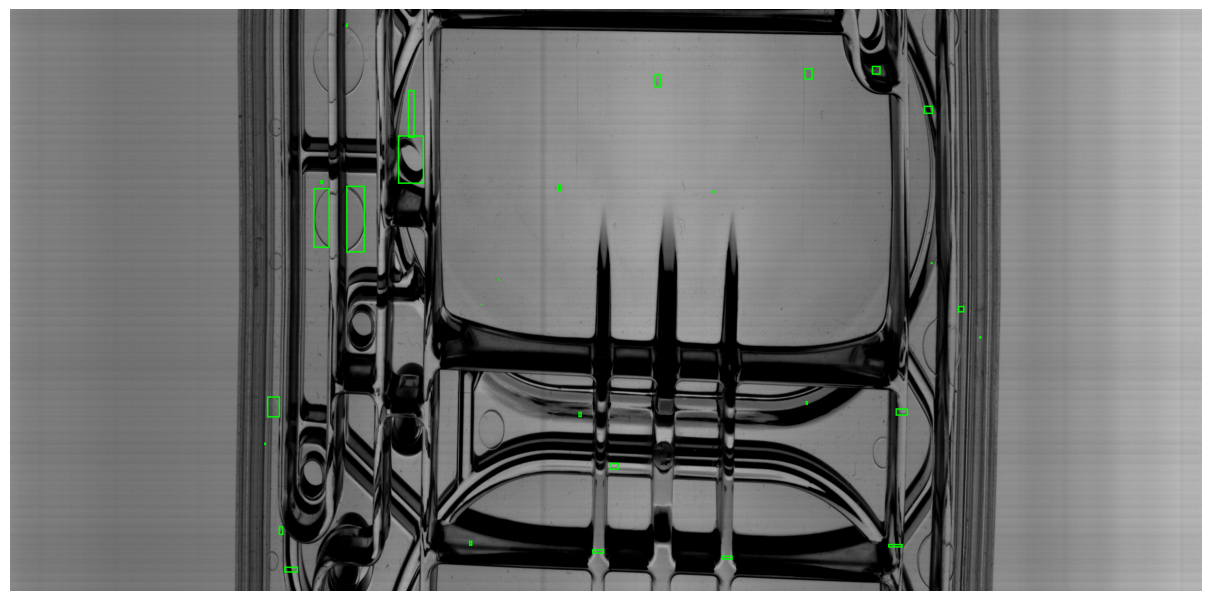

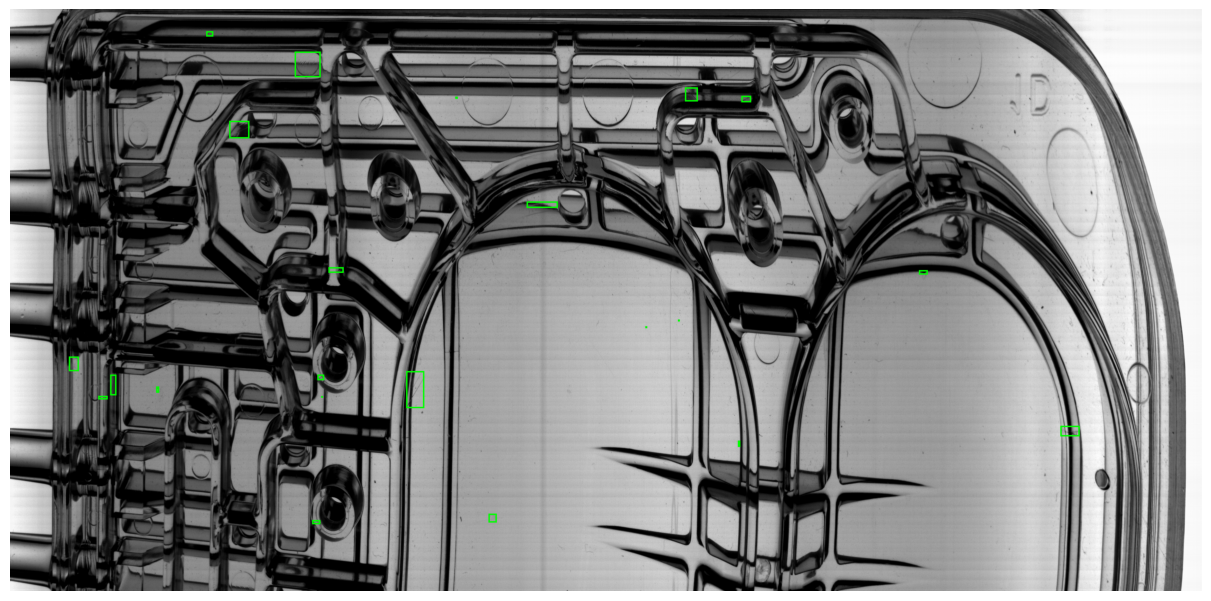

In [102]:
for img in coco_dict["images"]:
    fig, ax = plt.subplots(1, 1, figsize=(12, 9), constrained_layout=True)

    mono_img = Image.open(os.path.join(IMAGE_DIR,img["file_name"])).convert("L")
    rgb_img = Image.merge("RGB", (mono_img, mono_img, mono_img))

    # iterate over all annotations
    for ann_ind in range(len(coco_dict["annotations"])):
        
        if coco_dict["annotations"][ann_ind]["image_id"] == img["id"]:
            # convert coco bbox to pil bbox
            xywh = coco_dict["annotations"][ann_ind]["bbox"]
            xyxy = [xywh[0], xywh[1], xywh[0]+xywh[2], xywh[1]+xywh[3]]

            # visualize bbox over image
            ImageDraw.Draw(rgb_img).rectangle(xyxy, width=5, outline="lime")

    ax.axis("off")
    ax.imshow(rgb_img)
    #fig.savefig(os.path.join(BBOX_SAVE_DIR, img["file_name"][:-4] + ".png"))

In [103]:
slc_dict= load_json(SLC_ANNOTATION_PATH)
print(SLC_ANNOTATION_PATH)

slc_dict

..\data\coco\val\cassette1_val_sliced_coco.json


{'images': [{'height': 640,
   'width': 640,
   'id': 1,
   'file_name': '01BN02_0_0_0_640_640.png'},
  {'height': 640,
   'width': 640,
   'id': 2,
   'file_name': '01BN02_0_512_0_1152_640.png'},
  {'height': 640,
   'width': 640,
   'id': 3,
   'file_name': '01BN02_0_1024_0_1664_640.png'},
  {'height': 640,
   'width': 640,
   'id': 4,
   'file_name': '01BN02_0_1536_0_2176_640.png'},
  {'height': 640,
   'width': 640,
   'id': 5,
   'file_name': '01BN02_0_2048_0_2688_640.png'},
  {'height': 640,
   'width': 640,
   'id': 6,
   'file_name': '01BN02_0_2560_0_3200_640.png'},
  {'height': 640,
   'width': 640,
   'id': 7,
   'file_name': '01BN02_0_3072_0_3712_640.png'},
  {'height': 640,
   'width': 640,
   'id': 8,
   'file_name': '01BN02_0_3456_0_4096_640.png'},
  {'height': 640,
   'width': 640,
   'id': 9,
   'file_name': '01BN02_0_0_512_640_1152.png'},
  {'height': 640,
   'width': 640,
   'id': 10,
   'file_name': '01BN02_0_512_512_1152_1152.png'},
  {'height': 640,
   'width': 640

In [104]:
for img in slc_dict["images"]:
    fig, ax = plt.subplots(1, 1, figsize=(12, 9), constrained_layout=True)
    
    # Open the sliced image file in grayscale, convert it to RGB
    sliced_img_path = os.path.join(SLICED_IMAGE_DIR, img["file_name"])
    mono_img = Image.open(sliced_img_path).convert("L")
    rgb_img = Image.merge("RGB", (mono_img, mono_img, mono_img))
    
    # Iterate over all annotations for this specific image
    for annotation in slc_dict["annotations"]:
        if annotation["image_id"] == img["id"]:
            # Extract and convert bounding box coordinates
            xywh = annotation["bbox"]
            xyxy = [xywh[0], xywh[1], xywh[0] + xywh[2], xywh[1] + xywh[3]]
            
            # Draw the bounding box on the image
            ImageDraw.Draw(rgb_img).rectangle(xyxy, width=5, outline="lime")
    
    # Display and save the image with bounding boxes
    ax.axis("off")
    ax.imshow(rgb_img)
    fig.savefig(os.path.join(BBOX_SAVE_DIR, img["file_name"][:-4] + ".png")) #save each of the image to folder called Each
    plt.close()

In [ ]:
os.mkdir(AUGMENTATION_PATH)

## Full image augmentation

In [89]:
'''
Mainly for COCO files. Not catered for YOLO
'''
import os
import cv2
import json
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from sahi.utils.file import load_json

# Define the main COCO file name
coco_file_name = "cassette1_train"


In [90]:
class ImageAugmentor:
    def __init__(self, coco_file_name, config, split="train", image_type="original"):
        self.split = split
        self.coco_file_name = coco_file_name
        self.config = config
        self.image_type = image_type

        self.DATA_DIR = config.get("DATA_DIR", "../data")
        self.AUGMENTATION_PATH = config.get("AUGMENTATION_PATH", os.path.join(self.DATA_DIR, "augmentation"))
        self.VISUALIZATION_DIR = config.get("VISUALIZATION_DIR", os.path.join(self.DATA_DIR, "bbox_vis"))

        image_subdir = "original_images" if self.image_type == "original" else "sliced_images"
        self.output_dir = os.path.join(self.AUGMENTATION_PATH, image_subdir, f"{split}_images")
        self.bbox_vis_dir = os.path.join(self.VISUALIZATION_DIR, coco_file_name, image_subdir)

        self.org_annotation_path = os.path.join(self.DATA_DIR, "coco", split, f"{coco_file_name}_corrected_coco.json")
        self.image_dir = os.path.join(self.DATA_DIR, "coco", "images_sliced" if self.image_type == "sliced" else "images")

        self._create_directories([self.output_dir, self.bbox_vis_dir])

        # Load COCO annotations and initialize augmented annotations structure
        self.coco_dict = load_json(self.org_annotation_path)
        self.augmented_annotations = {
            "images": [],
            "annotations": [],
            "categories": self.coco_dict["categories"]
        }
        self.annotation_id = 1  # Initialize annotation ID counter

    def _create_directories(self, directories):
        for directory in directories:
            os.makedirs(directory, exist_ok=True)

    def process_images(self):
        annotations_by_image = self._organize_annotations_by_image_id()
        
        for img in tqdm(self.coco_dict["images"], desc="Processing Images"):
            image_path = os.path.join(self.image_dir, img["file_name"])
            if not os.path.exists(image_path):
                print(f"Warning: Image {img['file_name']} not found.")
                continue
            
            image = self._load_image(image_path)
            bboxes, class_labels = self._extract_bboxes_and_labels(img["id"], annotations_by_image)
            
            # Apply and save each augmentation type separately
            self._apply_and_save(image, bboxes, class_labels, img["file_name"], "flip")
            self._apply_and_save(image, bboxes, class_labels, img["file_name"], "contrast")
            self._apply_and_save(image, bboxes, class_labels, img["file_name"], "noise")

    def _apply_and_save(self, image, bboxes, class_labels, filename, aug_type):
        if aug_type == "flip":
            augmentation = A.Compose([A.HorizontalFlip(p=1)], bbox_params=A.BboxParams(format='coco', label_fields=['class_labels']))
        elif aug_type == "contrast":
            augmentation = A.Compose([A.RandomBrightnessContrast(p=1)], bbox_params=A.BboxParams(format='coco', label_fields=['class_labels']))
        elif aug_type == "noise":
            augmentation = A.Compose([A.GaussNoise(var_limit=(10, 50), p=1)], bbox_params=A.BboxParams(format='coco', label_fields=['class_labels']))
        
        augmented = augmentation(image=image, bboxes=bboxes, class_labels=class_labels)
        augmented_image = augmented['image']
        augmented_bboxes = augmented['bboxes']

        # Save augmented image and bbox visualization
        save_filename = f"{filename[:-4]}_{aug_type}.png"
        self._save_augmented_image(augmented_image, save_filename)
        self._visualize_augmented_with_bboxes(augmented_image, augmented_bboxes, save_filename, aug_type)

        # Save augmented annotation
        self._save_augmented_annotation(save_filename, augmented_bboxes, class_labels, img_width=augmented_image.shape[1], img_height=augmented_image.shape[0])

    def _save_augmented_annotation(self, filename, bboxes, class_labels, img_width, img_height):
        image_entry = {
            "id": len(self.augmented_annotations["images"]) + 1,
            "file_name": filename,
            "width": img_width,
            "height": img_height
        }
        self.augmented_annotations["images"].append(image_entry)

        for bbox, label in zip(bboxes, class_labels):
            x, y, w, h = bbox
            annotation_entry = {
                "id": self.annotation_id,
                "image_id": image_entry["id"],
                "category_id": label,
                "bbox": [x, y, w, h],
                "area": w * h,
                "iscrowd": 0
            }
            self.augmented_annotations["annotations"].append(annotation_entry)
            self.annotation_id += 1

    def save_augmented_coco_json(self, output_path):
        with open(output_path, 'w') as f:
            json.dump(self.augmented_annotations, f)

    def _load_image(self, image_path):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        return cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    def _save_augmented_image(self, image, filename):
        output_path = os.path.join(self.output_dir, filename)
        image = image.permute(1, 2, 0).cpu().numpy()
        image = (image * 255).astype('uint8')
        cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

    def _visualize_augmented_with_bboxes(self, image, bboxes, filename, aug_type):
        # Convert image to PIL format for drawing bounding boxes
        pil_image = Image.fromarray((image * 255).astype(np.uint8)).convert("L")
        rgb_image = Image.merge("RGB", (pil_image, pil_image, pil_image))
        
        # Draw bounding boxes on the image
        draw = ImageDraw.Draw(rgb_image)
        for bbox in bboxes:
            x_min, y_min, width, height = bbox
            x_max, y_max = x_min + width, y_min + height
            draw.rectangle([x_min, y_min, x_max, y_max], outline="lime", width=3)

        save_path = os.path.join(self.bbox_vis_dir, f"{filename[:-4]}_{aug_type}_bbox.png")
        rgb_image.save(save_path)


    def _organize_annotations_by_image_id(self):
        annotations_by_image = {}
        for annotation in self.coco_dict["annotations"]:
            image_id = annotation["image_id"]
            if image_id not in annotations_by_image:
                annotations_by_image[image_id] = []
            annotations_by_image[image_id].append(annotation)
        return annotations_by_image

    def _extract_bboxes_and_labels(self, image_id, annotations_by_image):
        bboxes, class_labels = [], []
        if image_id in annotations_by_image:
            for annotation in annotations_by_image[image_id]:
                x, y, w, h = annotation["bbox"]
                bboxes.append([x, y, w, h])
                class_labels.append(annotation["category_id"])
        return bboxes, class_labels


def plot_augmented_bboxes_coco(annotation: dict, img_dir: str, save_dir: str, aug_type: str):
    os.makedirs(save_dir, exist_ok=True)

    for img in tqdm(annotation["images"], desc=f"Plotting {aug_type} augmented images with bounding boxes"):
        fig, ax = plt.subplots(1, 1, figsize=(12, 9), constrained_layout=True)
        mono_img = Image.open(os.path.join(img_dir, img["file_name"])).convert("L")
        rgb_img = Image.merge("RGB", (mono_img, mono_img, mono_img))

        for ann in annotation["annotations"]:
            if ann["image_id"] == img["id"]:
                xywh = ann["bbox"]
                xyxy = [xywh[0], xywh[1], xywh[0] + xywh[2], xywh[1] + xywh[3]]
                ImageDraw.Draw(rgb_img).rectangle(xyxy, width=3, outline="lime")

        ax.axis("off")
        ax.imshow(rgb_img)

        save_path = os.path.join(save_dir, f"{img['file_name'][:-4]}_{aug_type}_bbox.png")
        fig.savefig(save_path)
        plt.close()


In [91]:
def load_coco_as_dataframe(coco_path):
    with open(coco_path, 'r') as f:
        coco_data = json.load(f)

    categories = {cat["id"]: cat["name"] for cat in coco_data["categories"]}

    data = []
    for ann in coco_data["annotations"]:
        image_id = ann["image_id"]
        category_id = ann["category_id"]
        data.append({
            "image_id": image_id,
            "category_id": category_id,
            "class_name": categories[category_id],
            "bbox_x": ann["bbox"][0],
            "bbox_y": ann["bbox"][1],
            "bbox_width": ann["bbox"][2],
            "bbox_height": ann["bbox"][3]
        })
    
    return pd.DataFrame(data)

In [92]:
class AugmentationAnalyzer:
    def __init__(self, original_data, augmented_data):
        self.original_data = original_data
        self.augmented_data = augmented_data

    def plot_class_distribution(self):
        original_counts = self.original_data['class_name'].value_counts()
        augmented_counts = self.augmented_data['class_name'].value_counts()

        plt.figure(figsize=(10, 6))
        plt.bar(original_counts.index, original_counts.values, alpha=0.7, label="Original")
        plt.bar(augmented_counts.index, augmented_counts.values, alpha=0.7, label="Augmented")
        plt.xlabel("Class")
        plt.ylabel("Count")
        plt.title("Class Distribution Comparison")
        plt.legend()
        plt.show()


In [93]:
# Configuration for grayscale-friendly augmentations
config = {
    "DATA_DIR": "../data",
    "AUGMENTATION_PATH": "../data/augmentation",
    "VISUALIZATION_DIR": "../data/bbox_vis",
    "augmentation_params": {
        "horizontal_flip": 0.5,
        "brightness_contrast": 0.5,
        "blur": 3,
        "noise": 0.3,
        "normalize": True
    }
}

In [94]:
def run():
    # Verify if the original COCO file exists
    if not os.path.exists(config["DATA_DIR"] + "/coco/train/cassette1_train_corrected_coco.json"):
        print("Error: Original COCO file not found.")
        return
    
    # Augmentation
    augmentor_original = ImageAugmentor(coco_file_name=coco_file_name, config=config, split="train", image_type="original")
    augmentor_sliced = ImageAugmentor(coco_file_name=coco_file_name, config=config, split="train", image_type="sliced")
    augmentor_original.process_images()
    augmentor_sliced.process_images()

    # Save augmented COCO JSON files
    augmentor_original.save_augmented_coco_json("./data/augmentation/original_images/train_annotations_augmented_original.json")
    augmentor_sliced.save_augmented_coco_json("./data/augmentation/sliced_images/train_annotations_augmented_sliced.json")

    # Load original and augmented data for analysis
    original_data = load_coco_as_dataframe("./data/coco/train/cassette1_train_corrected_coco.json")
    augmented_data_path = "./data/augmentation/original_images/train_annotations_augmented_original.json"
    
    if not os.path.exists(augmented_data_path):
        print(f"Error: Augmented data not found at {augmented_data_path}.")
        return

    augmented_data = load_coco_as_dataframe(augmented_data_path)

    # Analysis
    analyzer = AugmentationAnalyzer(original_data, augmented_data)
    analyzer.plot_class_distribution()

if __name__ == "__main__":
    run()


Processing Images:   0%|          | 0/18 [00:00<?, ?it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'permute'